### Team Members:
- Bridget Crampton
- Everett Meehan
- Ryon Rezania
- Cassiel Chaluja

## Problem Motivation



## Summary of the Data Processing Pipeline
In order to process the data, we first need to acquire the data. We accomplished this by using the fetch_food_data() function to send get requests with specific parameters within a for loop, that iterates through a number of pages to get all the data. The json responses are then combined into one large pandas dataframe. The initial dataframe contains a nested dictionary with all the nutrients in one column. So, we use the extract_nutrients() function to take all the nutritional values and store them as their own respective feature. After that, the data is cleaned by dropping rows with incomplete macronutrients, and flagging rows that are under 70% complete on micronutrients. After this we use the calculate_nutrient_density() function to get the percentage of how much each nutrient fulfills the daily recommendation. Then it adds up all the percentage daily values(up to 100%), and uses that score to calculate the nutrient density score by dividing by the number of calories. We then apply all the functions for two different search queries, one for superfoods and one for just regular food. Then, one last boolean column is added, marked true for all the superfoods, and false for all the others. Finally, the two dataframes are combined into one. Once the data has been prepared, we use it to create a handful of visualizations. First, we made two histograms to show the difference in nutrient density between super and non-super foods, which can help us determine if there is a clear distinction between the two. Similarly, we created a scatter plot of micronutrient richness of super and non-super foods. The graph places foods based on their nutrient density score and how many calories per 100 grams they are. On top of that, the size of the points on the plot is determined by its micronutrient richness. The final visualizations are two heatmaps that display the relationships between nutrients in super versus non-superfoods. This is to see if there is a difference in relationships, which can help us determine nutrients that a the best at determining superfood status.

## Part 2:
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [97]:
# Import Necessary Libraries
import requests
import pandas as pd

In [99]:
def fetch_food_data(url, query, api_key, max_pages=25):
    """
    Fetch and combine paginated food data from USDA API.
    
    Args:
        url (str): API endpoint URL
        query (str): Search query term
        api_key (str): API authentication key
        max_pages (int): Maximum number of pages to fetch (default: 25)
    
    Returns:
        pd.DataFrame: Combined food data from all pages
    """
    params = {"query": query, "pageSize": 200, "api_key": api_key}
    response = requests.get(url, params=params)
    total_pages = min(response.json()['totalPages'], max_pages)
    
    all_foods = []
    for page in range(total_pages):
        params["page"] = page
        data = requests.get(url, params=params)
        all_foods.extend(data.json()['foods'])
    
    return pd.DataFrame(all_foods)

In [101]:
def extract_nutrients(df):
    """
    Extract nutrition information from foodNutrients and create columns.
    
    Args:
        df (pd.DataFrame): Raw food data with nested nutrient dictionaries
    
    Returns:
        pd.DataFrame: DataFrame with extracted nutrient columns
    """
    nutrient_data = []
    
    for idx, row in df.iterrows():
        row_nutrients = {}
        
        if isinstance(row['foodNutrients'], list):
            fat_total = 0
            protein = 0
            carbs = 0
            
            for nutrient in row['foodNutrients']:
                name = nutrient.get('nutrientName')
                value = nutrient.get('value')
                unit = nutrient.get('unitName')
                
                if name and unit:
                    row_nutrients[f'{name} ({unit})'] = value
                
                if 'Fatty acids' in name:
                    fat_total += value
                elif name == 'Protein':
                    protein = value
                elif name == 'Carbohydrate, by difference':
                    carbs = value
            
            row_nutrients['Total Fat (G)'] = fat_total
            row_nutrients['Calories'] = (protein * 4) + (carbs * 4) + (fat_total * 9)
        
        nutrient_data.append(row_nutrients)
    
    return pd.concat([df, pd.DataFrame(nutrient_data)], axis=1)

In [103]:
def clean_food_data(df, micro_start_col=32, micro_end_col=147):
    """
    Clean food data by removing incomplete records and flagging micronutrient completeness.
    
    Args:
        df (pd.DataFrame): Food data with nutrient columns
        micro_start_col (int): Starting column index for micronutrients
        micro_end_col (int): Ending column index for micronutrients
    
    Returns:
        pd.DataFrame: Cleaned dataframe with completeness flag
    """
    macros = ['Protein (G)', 'Carbohydrate, by difference (G)', 'Total Fat (G)', 'Calories']
    df_cleaned = df.dropna(subset=macros).copy()
    
    # Flag rows with <70% micronutrient completeness
    micro_cols = df_cleaned.columns[micro_start_col:micro_end_col]
    micro_null_ratio = df_cleaned[micro_cols].isnull().sum(axis=1) / len(micro_cols)
    df_cleaned['<70% micronutrients completeness'] = micro_null_ratio < 0.7
    
    return df_cleaned

In [105]:
def calculate_nutrient_density(df, daily_values=None):
    """
    Calculate percent daily values and nutrient density score for all foods.
    
    Args:
        df (pd.DataFrame): Food data with nutrient columns
        daily_values (dict): Dictionary of daily value recommendations (optional)
    
    Returns:
        pd.DataFrame: DataFrame with % Daily Value columns and Nutrient Density Score
    """
    if daily_values is None:
        daily_values = {
            # Macronutrients
            'protein': 50,
            'total_fat': 78,
            'saturated_fat': 20,
            'trans_fat': 0,
            'cholesterol': 300,
            'total_carbohydrate': 275,
            'dietary_fiber': 28,
            'total_sugars': None,
            'added_sugars': 50,
            # Vitamins
            'vitamin_a': 900,
            'vitamin_c': 90,
            'vitamin_d': 20,
            'vitamin_e': 15,
            'vitamin_k': 120,
            'thiamin': 1.2,
            'riboflavin': 1.3,
            'niacin': 16,
            'vitamin_b6': 1.7,
            'folate': 400,
            'vitamin_b12': 2.4,
            'biotin': 30,
            'pantothenic_acid': 5,
            'choline': 550,
            # Minerals
            'calcium': 1300,
            'iron': 18,
            'phosphorus': 1250,
            'iodine': 150,
            'magnesium': 420,
            'zinc': 11,
            'selenium': 55,
            'copper': 0.9,
            'manganese': 2.3,
            'chromium': 35,
            'molybdenum': 45,
            'chloride': 2300,
            'potassium': 4700,
            'sodium': 2300,
            # Calories
            'calories': 2000,
        }
    
    df_enriched = df.copy()
    
    # Calculate % Daily Value for each nutrient
    for nutrient, dv in daily_values.items():
        if dv is None:
            continue
        
        # Find matching column in dataframe
        nutrient_column = None
        for col in df_enriched.columns:
            if nutrient.lower() in col.lower():
                nutrient_column = col
                break
        
        if nutrient_column:
            new_column_name = f'{nutrient_column} (% Daily Value)'
            if new_column_name not in df_enriched.columns:
                df_enriched[new_column_name] = (df_enriched[nutrient_column] / dv) * 100
    
    # Calculate Total Nutrient % Daily Value (capped at 100% per nutrient, excluding calories)
    percentage_columns = [col for col in df_enriched.columns 
                         if col.endswith('(% Daily Value)') and 'Calories' not in col]
    
    if percentage_columns:
        capped_percentages = df_enriched[percentage_columns].clip(upper=100)
        df_enriched['Total Nutrient % Daily Value'] = capped_percentages.sum(axis=1)
        
        # Calculate Nutrient Density Score (nutrient density per calorie)
        df_enriched['Nutrient Density Score'] = (
            df_enriched['Total Nutrient % Daily Value'] / df_enriched['Calories']
        )
    
    return df_enriched

In [107]:
def process_superfood_analysis(url, api_key):
    """
    Complete pipeline for superfood vs regular food analysis.
    
    Args:
        url (str): USDA API endpoint
        api_key (str): API authentication key
    
    Returns:
        pd.DataFrame: Combined dataset with superfood labels
    """
    # Fetch both datasets
    print("Fetching regular foods...")
    df_regular = fetch_food_data(url, "food", api_key, max_pages=25)
    
    print("Fetching superfoods...")
    df_super = fetch_food_data(url, "superfood", api_key, max_pages=25)
    
    # Extract nutrients
    print("Extracting nutrients...")
    df_regular = extract_nutrients(df_regular)
    df_super = extract_nutrients(df_super)
    
    # Clean data
    print("Cleaning data...")
    df_regular = clean_food_data(df_regular)
    df_super = clean_food_data(df_super)
    
    # Calculate nutrient density
    print("Calculating nutrient density scores...")
    df_regular = calculate_nutrient_density(df_regular)
    df_super = calculate_nutrient_density(df_super)
    
    # Add labels
    df_regular['is_superfood'] = False
    df_super['is_superfood'] = True
    
    # Combine datasets
    df_combined = pd.concat([df_regular, df_super], ignore_index=True)
    
    print(f"\nProcessing complete!")
    print(f"Total foods: {len(df_combined)}")
    print(f"Regular foods: {len(df_regular)}")
    print(f"Superfoods: {len(df_super)}")
    
    return df_combined

In [116]:
# API credentials
url = "https://api.nal.usda.gov/fdc/v1/foods/search"
api_key = "GodjGTNmZedxuPZHaUdqYCBnTjy5Skh8lG7hrOYO"
    
   
print("Processing superfoods...")
super_df = fetch_food_data(url, "superfood", api_key, max_pages=25)
super_df = extract_nutrients(super_df)
super_cleaned = clean_food_data(super_df)
super_cleaned = calculate_nutrient_density(super_cleaned)
super_cleaned.to_csv('superfoods_tagged.csv', index=False)
print(f"Superfoods: {len(super_cleaned)} items saved to 'superfoods_tagged.csv'")
    
print("\nProcessing regular foods...")
other_df = fetch_food_data(url, "food", api_key, max_pages=25)
other_df = extract_nutrients(other_df)
other_cleaned = clean_food_data(other_df)
other_cleaned = calculate_nutrient_density(other_cleaned)
other_cleaned.to_csv('Foods_tagged.csv', index=False)
print(f"Regular foods: {len(other_cleaned)} items saved to 'Foods_tagged.csv'")
    
print("\nProcessing complete!")

Processing superfoods...
Superfoods: 1176 items saved to 'superfoods_tagged.csv'

Processing regular foods...
Regular foods: 4925 items saved to 'Foods_tagged.csv'

Processing complete!


## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

In [119]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

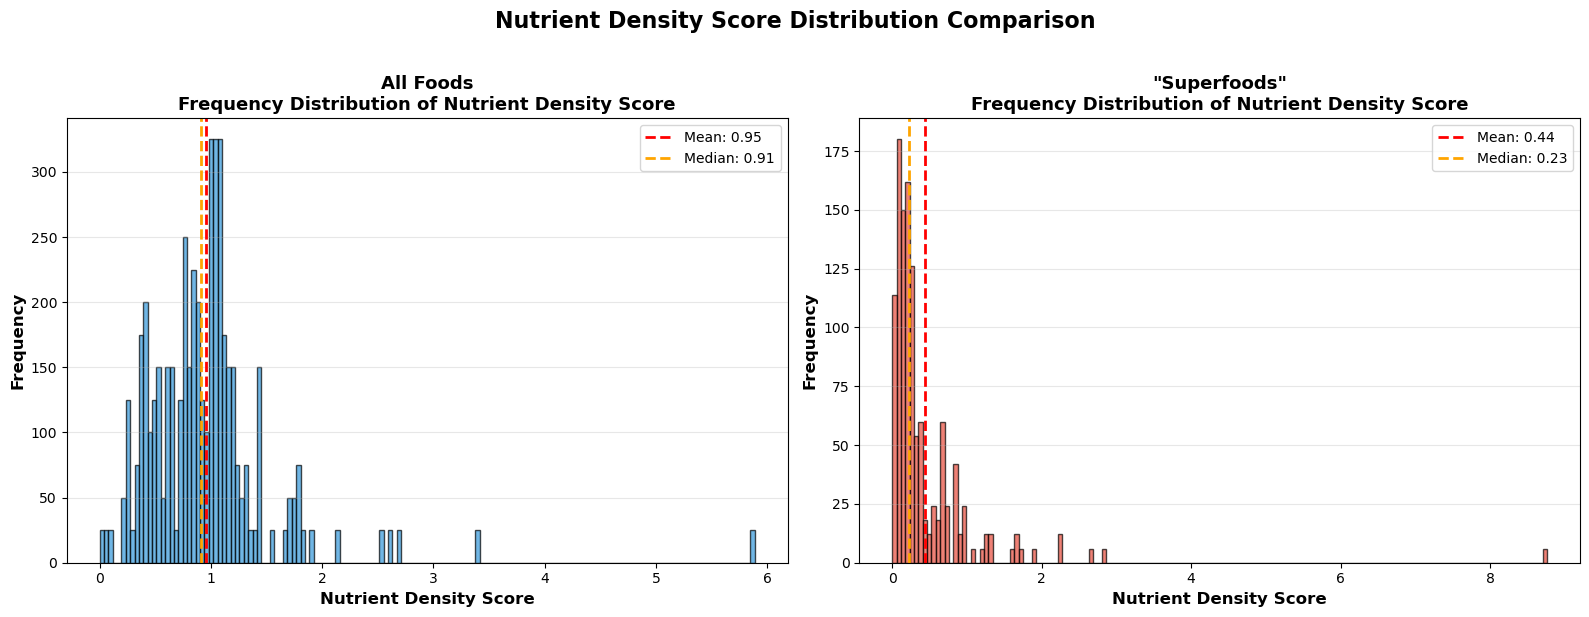

Regular Foods - Mean: 0.95, Median: 0.91, n=4925
Superfoods    - Mean: 0.44, Median: 0.23, n=1176


In [121]:
# Create figure with 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Regular Foods
ax1.hist(other_cleaned['Nutrient Density Score'], bins=150, color='#3498db', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Nutrient Density Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('All Foods\nFrequency Distribution of Nutrient Density Score', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add statistics
mean_regular = other_cleaned['Nutrient Density Score'].mean()
median_regular = other_cleaned['Nutrient Density Score'].median()
ax1.axvline(mean_regular, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_regular:.2f}')
ax1.axvline(median_regular, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_regular:.2f}')
ax1.legend()

# Plot 2: Superfoods
ax2.hist(super_cleaned['Nutrient Density Score'], bins=150, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Nutrient Density Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('"Superfoods"\nFrequency Distribution of Nutrient Density Score', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add statistics
mean_super = super_cleaned['Nutrient Density Score'].mean()
median_super = super_cleaned['Nutrient Density Score'].median()
ax2.axvline(mean_super, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_super:.2f}')
ax2.axvline(median_super, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_super:.2f}')
ax2.legend()

plt.suptitle('Nutrient Density Score Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Regular Foods - Mean: {mean_regular:.2f}, Median: {median_regular:.2f}, n={len(other_cleaned)}")
print(f"Superfoods    - Mean: {mean_super:.2f}, Median: {median_super:.2f}, n={len(super_cleaned)}")

In [123]:
def calculate_metrics(df, food_type):
    """Calculate key metrics for analysis"""
    # Nutrient efficiency
    df['nutrient_per_calorie'] = df['Total Nutrient % Daily Value'] / df['Calories']
    
    # Micronutrient richness (average % DV across all micronutrients)
    micro_dv_cols = [col for col in df.columns if '(% Daily Value)' in col and 'Calories' not in col]
    df['micronutrient_richness'] = df[micro_dv_cols].mean(axis=1)
    
    # Add label
    df['food_type'] = food_type
    
    return df

In [125]:
# Apply metrics to both datasets
super_cleaned = calculate_food_metrics(super_cleaned)
other_cleaned = calculate_food_metrics(other_cleaned)

# Add labels
super_cleaned['food_type'] = 'Superfood'
other_cleaned['food_type'] = 'Regular Food'

# Combine for comparison
df_combined = pd.concat([super_cleaned, other_cleaned], ignore_index=True)

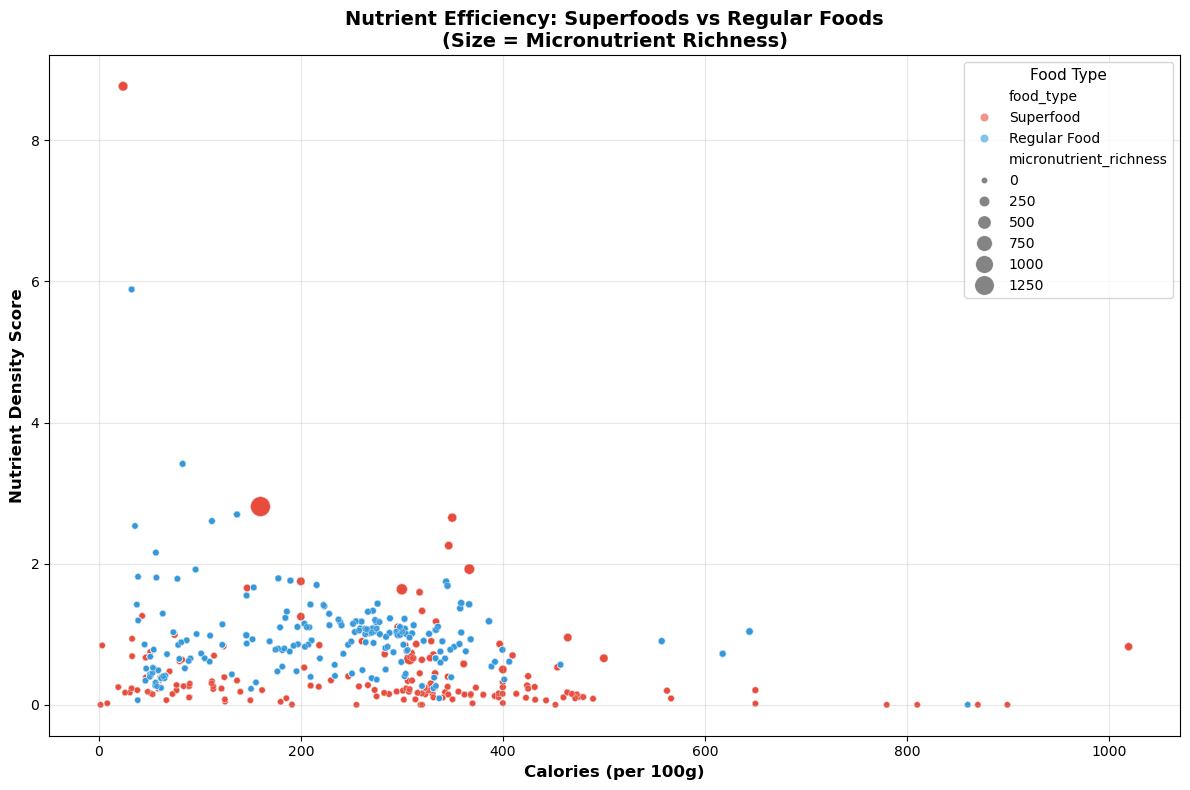

In [127]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    data=df_combined, 
    x='Calories', 
    y='Nutrient Density Score',
    hue='food_type',
    size='micronutrient_richness',
    sizes=(20, 200),
    alpha=0.6,
    palette={'Superfood': '#e74c3c', 'Regular Food': '#3498db'},
    ax=ax
)

ax.set_xlabel('Calories (per 100g)', fontsize=12, fontweight='bold')
ax.set_ylabel('Nutrient Density Score', fontsize=12, fontweight='bold')
ax.set_title('Nutrient Efficiency: Superfoods vs Regular Foods\n(Size = Micronutrient Richness)', 
             fontsize=14, fontweight='bold')
ax.legend(title='Food Type', fontsize=10, title_fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

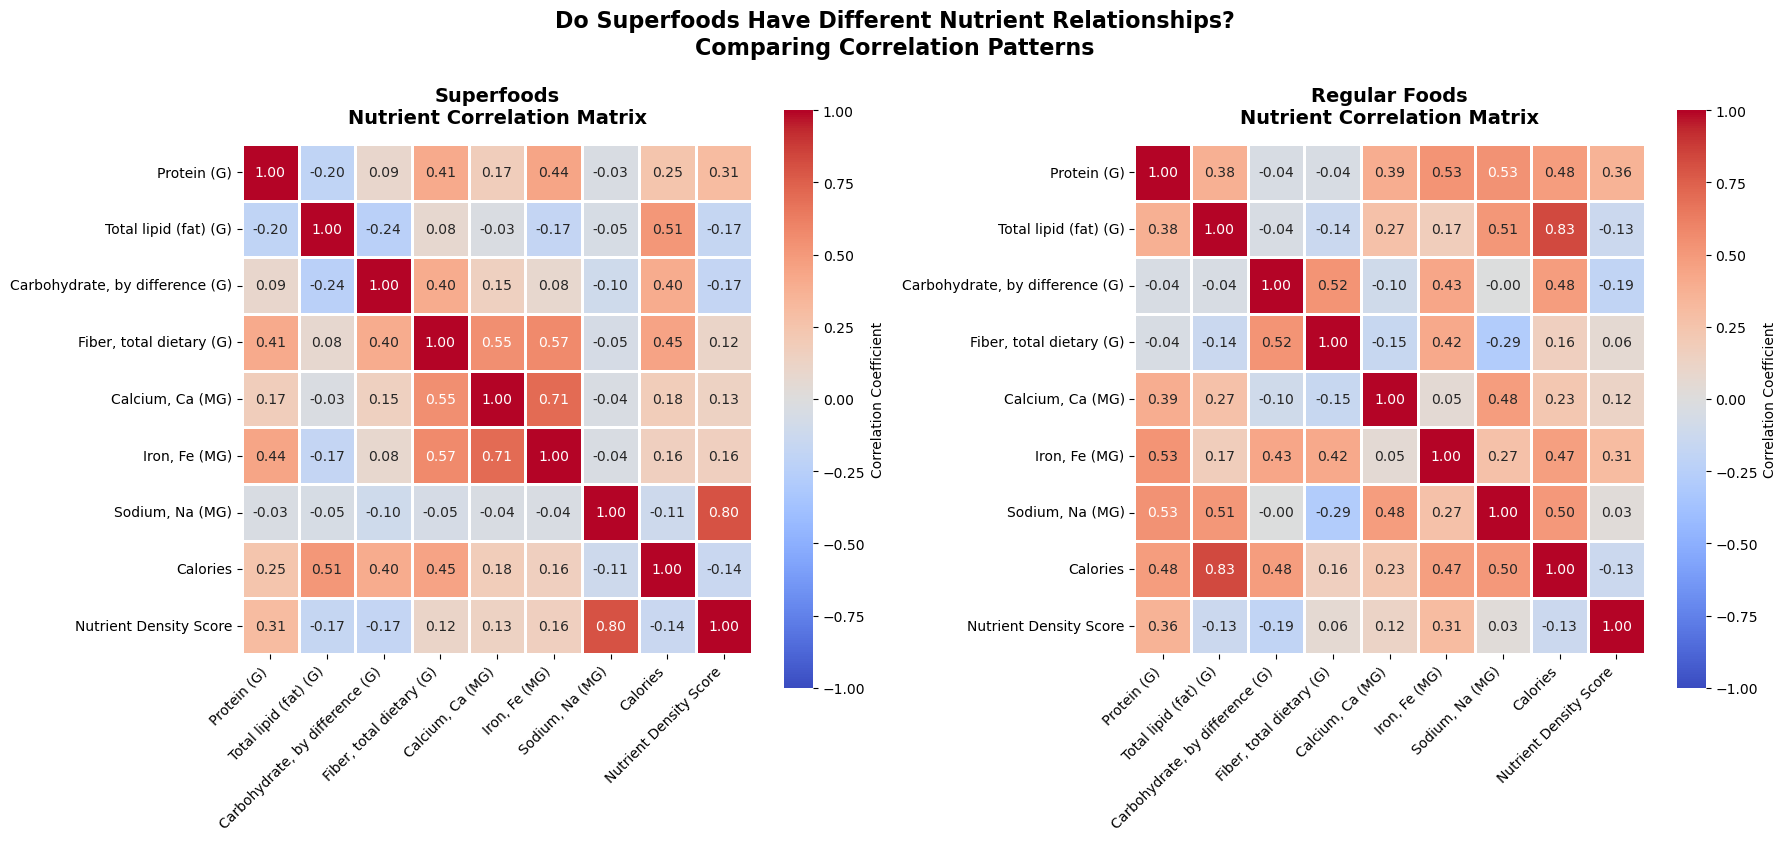

In [129]:
# Select key nutrients that exist in both datasets
nutrient_cols = [
    'Protein (G)', 
    'Total lipid (fat) (G)', 
    'Carbohydrate, by difference (G)',
    'Fiber, total dietary (G)', 
    'Calcium, Ca (MG)', 
    'Iron, Fe (MG)', 
    'Sodium, Na (MG)',
    'Calories',
    'Nutrient Density Score'
]

# Filter to only columns that exist
available_cols = [col for col in nutrient_cols if col in super_cleaned.columns and col in other_cleaned.columns]

# Calculate correlation matrices
corr_super = super_cleaned[available_cols].corr()
corr_regular = other_cleaned[available_cols].corr()

# Create side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Superfoods correlation
sns.heatmap(corr_super, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f', ax=ax1,
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1)
ax1.set_title('Superfoods\nNutrient Correlation Matrix', fontweight='bold', fontsize=14, pad=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)

# Regular foods correlation
sns.heatmap(corr_regular, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f', ax=ax2,
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1)
ax2.set_title('Regular Foods\nNutrient Correlation Matrix', fontweight='bold', fontsize=14, pad=15)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.suptitle('Do Superfoods Have Different Nutrient Relationships?\nComparing Correlation Patterns', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('viz4_correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()